# Урок 8. Python применение статистических критериев на практике - пайплайн оценки A/B

In [1]:
import numpy as np
import pandas as pd

import scipy.stats as stats
import statsmodels.stats as sm
from statsmodels.stats import proportion
from statsmodels.stats.power import TTestIndPower

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
#warnings.warn('DelftStack')
#warnings.warn('Do not show this message')

***
## Гипотеза для коэффициента корелляции

$H_0: corr = 0 \\
H_1: corr \not= 0$

In [2]:
data1 = [0.873, 2.817, 0.121, -0.945, -0.055, -1.436, 0.360, -1.478, -1.637, -1.869]
data2 = [0.353, 3.517, 0.125, -7.545, -0.555, -1.536, 3.350, -1.578, -3.537, -1.579]

stat, p = stats.pearsonr(data1, data2)

print('stat=%.3f, p=%.3f' % (stat, p))
if p < 0.05:
    print('Groups are different (reject H0)')
else:
    print('Groups are similar (fail to reject H0)')

stat=0.688, p=0.028
Groups are different (reject H0)


Отвергаем $H_0: corr = 0$

***
## Поработаем с датасетом c покупками

ARPU (Average Revenue Per User) - является производным показателем, рассчитывается как средневзвешенное за период агрегации значение Платежи LT/Регистрации. Отображает прибыль, полученную нами с 1 регистрации пользователя.

ARPPU (Average Revenue Per Paying User) - средний платеж платящего пользователя. Рассчитывается как средневзвешенное значение (Платежи LT/Впервые заплативших LT) за период агрегации. Показывает, сколько, в среднем, платит пользователь, ставший платящим, и, зарегистрированный в период агрегации, за всю жизнь.

### Подготовка данных

In [3]:
df = pd.read_csv('ab_stats.csv')
df.head(10)

,revenue,num_purchases,purchase,ab_group,av_site visit
0,0.0,0,0,A,9.040174
1,0.0,0,0,A,4.811628
2,0.0,0,0,A,7.342623
3,0.0,0,0,A,7.744581
4,0.0,0,0,A,10.511814
5,0.0,0,0,A,9.578727
6,0.0,0,0,A,6.162601
7,0.0,0,0,A,11.909452
8,0.0,0,0,A,6.540910
9,0.0,0,0,A,7.990794


revenue - выручка
num_purchases - кол-во покупок
purchase - факт покупки
ab_group - A/B группы
av_site visit - кол-во визитов в среднем на пользователя

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23652 entries, 0 to 23651
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        23652 non-null  float64
 1   num_purchases  23652 non-null  int64  
 2   purchase       23652 non-null  int64  
 3   ab_group       23652 non-null  object 
 4   av_site visit  23652 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 924.0+ KB


In [5]:
df.describe()

,revenue,num_purchases,purchase,av_site visit
count,23652.000000,23652.000000,23652.000000,23652.000000
mean,0.324689,0.043590,0.020717,7.013112
std,9.557730,1.079403,0.142438,3.154584
min,0.000000,0.000000,0.000000,-12.073486
25%,0.000000,0.000000,0.000000,5.173787
50%,0.000000,0.000000,0.000000,7.007936
75%,0.000000,0.000000,0.000000,8.864119
max,1303.609284,152.000000,1.000000,22.446822


In [6]:
df.isna().sum()

revenue          0
num_purchases    0
purchase         0
ab_group         0
av_site visit    0
dtype: int64

In [7]:
df['ab_group'].value_counts()

A    11835
B    11817
Name: ab_group, dtype: int64

In [8]:
df[df['revenue']>0]

,revenue,num_purchases,purchase,ab_group,av_site visit
45,1.885595,1,1,A,7.654627
54,1.002159,1,1,A,6.392489
82,2.990000,1,1,A,8.596604
104,49.990000,1,1,A,8.885633
110,22.093757,4,1,A,8.708759
...,...,...,...,...,...
23426,2.489611,1,1,B,9.015714
23493,74.950000,5,1,B,5.881950
23495,3.667866,1,1,B,7.450014
23584,19.990000,1,1,B,9.813696


### Посмотрим на группы отдельно

In [9]:
df[df['ab_group']=='A'].describe()

,revenue,num_purchases,purchase,av_site visit
count,11835.000000,11835.000000,11835.000000,11835.000000
mean,0.404462,0.050697,0.021631,6.974724
std,13.133218,1.467511,0.145481,2.023533
min,0.000000,0.000000,0.000000,-12.073486
25%,0.000000,0.000000,0.000000,5.656155
50%,0.000000,0.000000,0.000000,6.982329
75%,0.000000,0.000000,0.000000,8.345572
max,1303.609284,152.000000,1.000000,17.728836


In [10]:
df[df['ab_group']=='B'].describe()

,revenue,num_purchases,purchase,av_site visit
count,11817.000000,11817.000000,11817.000000,11817.000000
mean,0.244794,0.036473,0.019802,7.051559
std,3.176534,0.418480,0.139325,3.976799
min,0.000000,0.000000,0.000000,-8.286822
25%,0.000000,0.000000,0.000000,4.380984
50%,0.000000,0.000000,0.000000,7.060873
75%,0.000000,0.000000,0.000000,9.768648
max,113.830000,25.000000,1.000000,22.446822


Пока мы еще ничего не посчитали, но уже можно заметить, что максимальный чек в первой группе сильно больше, чем в группе B. Все мы знаем, что среднее очень неустойчиво к выбросам, так что нам необходимо будет это учесть.

### Проверка на нормальность распределения и применение статистических критериев

#### Метрика визиты на юзера

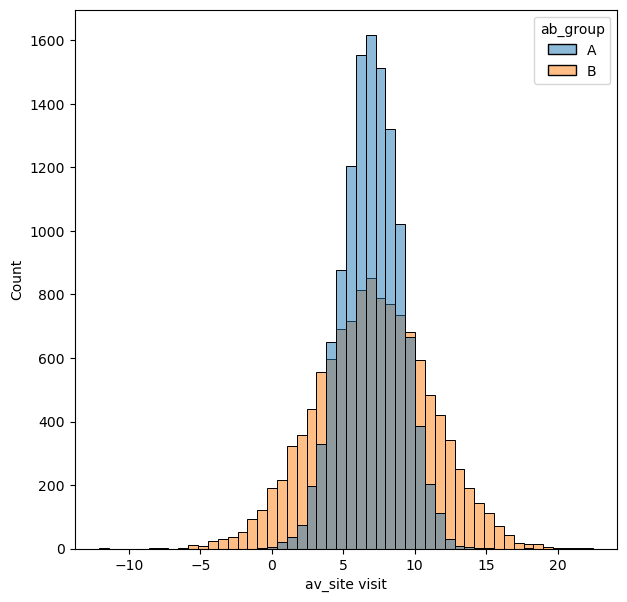

In [11]:
plt.figure(figsize=(7, 7))
sns.histplot(data=df, x='av_site visit', bins=50, hue='ab_group');

In [12]:
A = df[df['ab_group']=='A']['av_site visit']
B = df[df['ab_group']=='B']['av_site visit']

stats.ttest_ind(A, B, equal_var = False)

Ttest_indResult(statistic=-1.872183970103851, pvalue=0.06119777801292236)

#### Метрика доля юзеров с покупкой

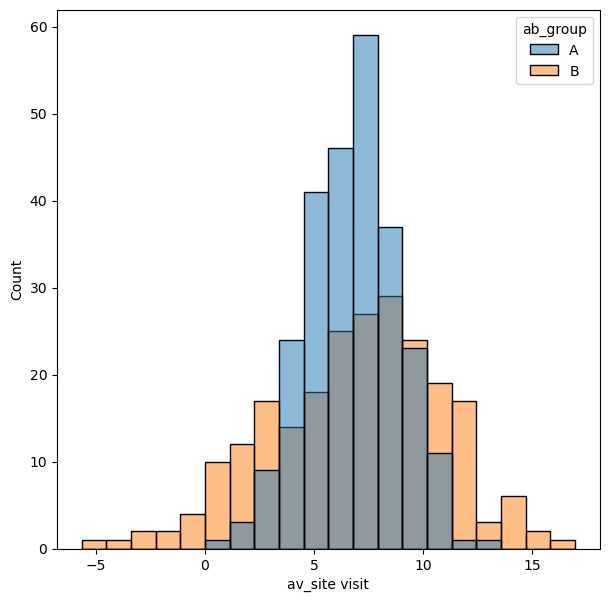

In [13]:
plt.figure(figsize=(7, 7))
sns.histplot(data=df[df['purchase']==1], x='av_site visit', bins=20, hue='ab_group');

In [14]:
df['purchase'].value_counts()

0    23162
1      490
Name: purchase, dtype: int64

**Z-тест пропорций**

$H_0: p_1 = p_2 \\
H_1: p1 \not= p_2$

$p_1 = \cfrac{m_1}{n_1}, p_2 = \cfrac{m_2}{n_2}$

In [15]:
m1 = df[df['ab_group']=='A']['purchase'].sum()
m2 = df[df['ab_group']=='B']['purchase'].sum()

n1 = df[df['ab_group']=='A'].shape[0]
n2 = df[df['ab_group']=='B'].shape[0]

z_score, z_pvalue = proportion.proportions_ztest(np.array([m1, m2]), np.array([n1, n2]))
print('Results are ','z_score =%.3f, pvalue = %.3f'%(z_score, z_pvalue))
if abs(z_pvalue) < 0.05:
    print("We may reject the null hypothesis!")
else:
    print("We have failed to reject the null hypothesis")

Results are  z_score =0.987, pvalue = 0.323
We have failed to reject the null hypothesis


Принимаем $H_0: p_1 = p_2$

**Непараметрический Хи-квадрат**

In [16]:
chisq, pvalue, table = proportion.proportions_chisquare(np.array([m1, m2]), np.array([n1, n2]))
print('Results are ','chisq =%.3f, pvalue = %.3f'%(chisq, pvalue))
if abs(pvalue) < 0.05:
    print("We may reject the null hypothesis!")
else:
    print("We have failed to reject the null hypothesis")

Results are  chisq =0.975, pvalue = 0.323
We have failed to reject the null hypothesis


Принимаем $H_0: p_1 = p_2$. 

#### Метрика ARPU

In [17]:
df.groupby('ab_group')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
ab_group,,,,,,,,
A,11835.0,0.404462,13.133218,0.0,0.0,0.0,0.0,1303.609284
B,11817.0,0.244794,3.176534,0.0,0.0,0.0,0.0,113.830000


Данные распределены ненормально, поэтому нужно использовать **непараметрический критерий Манна-Уитни**.

In [18]:
stats.mannwhitneyu(x=df[(df['ab_group'] == 'A')]['revenue'].values,
                   y=df[(df['ab_group'] == 'B')]['revenue'].values)

MannwhitneyuResult(statistic=70054756.0, pvalue=0.3243889561742552)

Принимаем $H_0$ о равенстве метрик ARPU в контрольной и тестовой группах.

#### Метрика среднее количество покупок на пользователя

In [19]:
stats.mannwhitneyu(x=df[(df['ab_group'] == 'A')]['num_purchases'].values,
                   y=df[(df['ab_group'] == 'B')]['num_purchases'].values)

MannwhitneyuResult(statistic=70054599.0, pvalue=0.3249718497892071)

Статистичнески значимых различий между группами нет.

#### Метрика ARPPU

In [20]:
stats.mannwhitneyu(x=df[(df['ab_group'] == 'A') & (df['purchase'] == 1)]['revenue'].values,
                   y=df[(df['ab_group'] == 'B') & (df['purchase'] == 1)]['revenue'].values)

MannwhitneyuResult(statistic=29729.5, pvalue=0.8871956616344514)

Статистически назнчимых различий нет.

Выкатывать изменения с тестовой группы не целесообразно, т.к. результаты теста и контроля по основным метрикам не различаются и основания отвергнуть нулевую гипотезу (о принадлежности выборок одной генеральной совокупности?) нет.

***
## Рассмотрим кейс с рекламной выручкой



In [21]:
df = pd.read_excel('test.xlsx')
df.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [23]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [24]:
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [25]:
df['VARIANT_NAME'].value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

Избавимся от некорретных строк. Посчитаем, сколько типов встречается у каждого пользователя.

In [26]:
double = df.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': pd.Series.nunique}).query('VARIANT_NAME > 1')
double

,USER_ID,VARIANT_NAME
1,3,2
6,10,2
11,18,2
15,25,2
23,40,2
...,...,...
6310,9978,2
6311,9979,2
6313,9982,2
6321,9996,2


In [27]:
df = df[~df['USER_ID'].isin(double['USER_ID'])].sort_values('USER_ID').reset_index(drop=True)
df

,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,2,control,0.0
2,2,control,0.0
3,4,variant,0.0
4,5,variant,0.0
...,...,...,...
6065,9992,control,0.0
6066,9993,control,0.0
6067,9995,variant,0.0
6068,9995,variant,0.0


Проверим данные на нормальность. Применим тест Шапиро-Уилко, т.к. у нас меньше 5000 наблюдений.

In [28]:
alpha = 0.05
stats.shapiro(df['REVENUE'])

ShapiroResult(statistic=0.015946388244628906, pvalue=0.0)

Данные распределены ненормально.

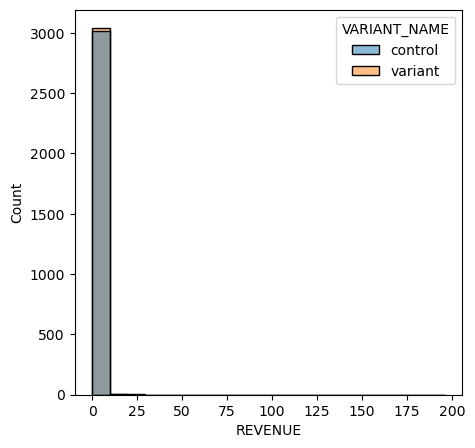

In [29]:
plt.figure(figsize=(5, 5))
sns.histplot(data=df, x='REVENUE', bins=20, hue='VARIANT_NAME');

Применим критерий Мана-Утни.

In [30]:
A = df.query('VARIANT_NAME == "control"')
B = df.query('VARIANT_NAME == "variant"')
stats.mannwhitneyu(x=A['REVENUE'].values, y=B['REVENUE']. values)

MannwhitneyuResult(statistic=4622832.0, pvalue=0.2444173738649208)

p-value > 0.05 следовательно статистически значимой разницы нет

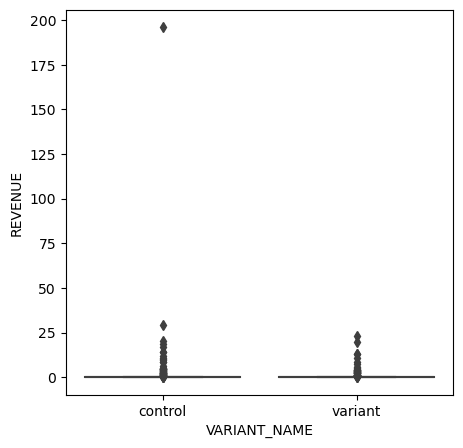

In [31]:
plt.figure(figsize=(5, 5))
sns.boxplot(data=df, y='REVENUE', x='VARIANT_NAME');

Применим t-тест

In [32]:
stats.ttest_ind(A['REVENUE'].values, B['REVENUE'].values, equal_var = False)

Ttest_indResult(statistic=1.403762252371675, pvalue=0.1604844017690842)

Не можем опровергнуть $H_0$ и казать, что группы стстистически значимо отличаются. Возможно недостаточно большая выборка.

## Расчет мощности
вероятность зафиксировать дезультат между группами, кодгда он действительно есть.

$d = \cfrac{m_1-m_2}{S_{pooled}}$

$S_{pooled} = \sqrt{\cfrac{S_1^2 + S_2^2}{2}}$ для двух одинаковых выборок

$S_{pooled} = \sqrt{\cfrac{(n_1-1)S_1^2+(n_2-1)S_2^2}{n_1+n_2-2}}$

In [33]:
Ma, Mb = A['REVENUE'].mean(), B['REVENUE'].mean()
Da, Db = A['REVENUE'].var(), B['REVENUE'].var()
Na, Nb = A.shape[0], B.shape[0]

In [34]:
effect_size = (Ma-Mb)/np.sqrt((Da + Db)/2)
effect_size

0.03608463308731012

In [35]:
analysis = TTestIndPower()
analysis.solve_power(effect_size=effect_size, alpha=alpha, power=None, nobs1=Na, ratio=1.0)

0.28928815581476947

In [36]:
effect_size = (Ma-Mb)/np.sqrt(((Na-1)*Da + (Nb-1)*Db)/(Na+Nb-2))
effect_size

0.03613393652648679

In [37]:
analysis = TTestIndPower()
analysis.solve_power(effect_size=effect_size, alpha=alpha, power=None, nobs1=Na, ratio=Nb/Na)

0.2906509861500628

Мощность теста в районе 29%. С такой мощностью мы не можем быть уверены в результатах теста. Мы могли не получить статистически значимую разницу, т.к. у нас недостаточный объем выборки для таких дисперсий, для такой метрики.

Мы не обнаружили статистически значимую разницу по одной из наших ключевых метрик. Сам тест вызывает сомнения - одни и те же пользователи попадали в контрольную и тестовую группу.